# Data analysis for HRV and MET received through device

Using MAXIM maxref103 to receive data through bluetooth. 

Data received come in the format of raw PPG with peak detection and accelerometer with sampling of around 25 samples a second. 

In [ ]:
import pandas as pd

import csv 

with open('processed_data.csv', 'w', newline='') as csvfile:
    fieldnames = ['index', 'duration', 'RMSSD', 'pNN50', 'HF', 'LF', 'HF/LF', 'MET', 'temperature', 'thermal_comfort']
    writer = csv.DictWriter(csvfile, fieldnames= fieldnames)
    writer.writeheader()

In [2]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## First, HRV

In [3]:
df = pd.read_csv("001.csv")

### Get and plot data

In [4]:
#get magnitude of PPG measurement
amp = df['green']
amp_array = amp.to_numpy()

samples = df['sample_count']
rr = df['rr']
timestamp = df['sample_time']

#normalize
max = np.max(amp_array)
min = np.min(amp_array)

amp_array_norm = (amp_array - min) / (max - min)

#get synthetic acceleration 
acx = df['acceleration_x']
acy = df['acceleration_y']
acz = df['acceleration_z']

syn_ac = np.square(acx) + np.square(acy) + np.square(acz)
syn_ac = np.power(syn_ac, 1/2)

#get rr and clean rr
rr_nz = rr[rr!=0]
rr_array = rr_nz.to_numpy()

#### Denoising by outlier detection and removal. Zero time data have already been removed from RR interval signal (since it is sampled at the same time as raw PPG)

Remains to be done: try denoising by acceleration. 

In [6]:
#do IQR on RR signal to remove outliers and clean rr
import numpy as np

Q1 = np.percentile(rr_array, 25)
Q3 = np.percentile(rr_array, 75)

IQR = Q3 - Q1

#print(IQR)

iqr_min = Q1 - 1.5*IQR
iqr_max = Q3 + 1.5*IQR

rr_array_clean = rr_array[(rr_array <iqr_max) & (rr_array>iqr_min)]


#### Plotting PPG, RR interval and acceleration signals to notice noise trends.

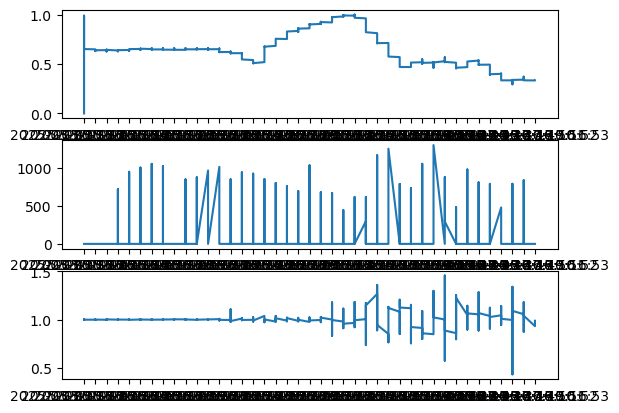

In [5]:
#get the PPG, RR, acc plot
figure, axis = plt.subplots(3)
axis[0].plot(timestamp, amp_array_norm)
axis[1].plot(timestamp, rr)
axis[2].plot(timestamp, syn_ac)

#rr plot seems to follow the direction of PPG measurement as opposed to acceleration which appears to be random here making everything a bit complicated 

### TIME ANALYSIS

#### RMSSD

In [9]:
import numpy as np

#RMSSD 
#removing all zero values to get only actual IBIs
rr_nz = rr[rr!=0]

#RMSSD: root mean square of successive differences
#turn this into a function at some point 
rr_nz_array = rr_nz.to_numpy() #float64 

itersize = rr_nz_array.size
squares = 0

for i in range(itersize-2) : 
    squares += np.square(rr_nz_array[i+1] - rr_nz_array[i])

average = squares / (itersize-1)

RMSSD = np.power(average, 1/2)

print(RMSSD)

#you get RMSSD here but you need to use that later to compare between different samples
#turn it into a function to use whenever 


259.94719656114773


#### pNN50

NN50/total_NN

In [10]:
def NN50count(data_array): 
    #counts count of relevant beats
    #should be given array of correct size for 2 min epoch 

    NN50count = 0
    for i in range(data_array.size - 1):
        if np.abs(data_array[i+1]-data_array[i]) > 50: 
            NN50count += 1     

    pNN50 = NN50count/data_array.size
    return pNN50

def windowing(time_array, start): 
    #make two minute epoch window to run through the whole database
    #returns end of array given start to have a two minute epoch as well as the next start for new iteration

    timer = 0
    counter = 0
    while ((time_array.iloc[timer] - time_array.iloc[start]).seconds<120): 
        counter += 1
        timer = start + counter
        if (time_array.iloc[timer] - time_array.iloc[start]).seconds == 30: 
            new_start = timer
        if (time_array.iloc[timer] == time_array.iloc[-1]): 
            break
    end = timer

    return end, new_start

def pNN50(time_array): 

    start = 0
    end = 0
    percs = []
    while (end != time_array.iloc[-1]):
        end, new_start = windowing(time_array, start)
        count_array = time_array.iloc[start:end]
        pNN50 = NN50count(count_array)
        percs.append[pNN50]
        start = new_start

    return percs

In [11]:
import numpy as np 
import pandas as pd
from statistics import mean
#pNN50 is the percentage of counts exceeding/following their next count by 50 ms within two minutes 
#our timestamp is samples that contain time but don't explicitely express it which means we first need to manipulate those
timestamp = df['timestamp']

time = pd.to_datetime(timestamp)

percentages = pNN50(time)

pNN50_total = mean(percentages)


TypeError: '>' not supported between instances of 'Timedelta' and 'int'

### SPECTRAL ANALYSIS

#### FFT with interpolation and clean data

In [12]:
from scipy.fft import rfft, rfftfreq
from scipy.fft import fft, fftfreq

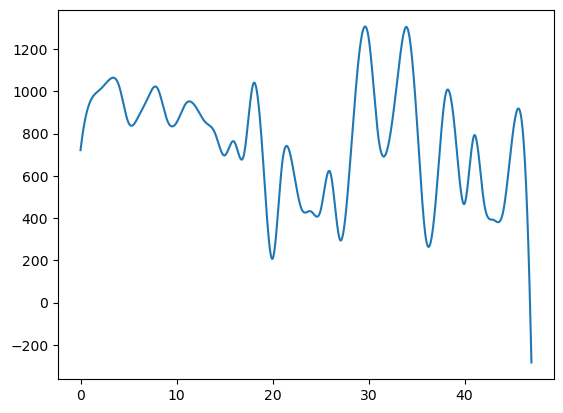

In [13]:
#gets and plots interpolated time data of RR interval
fs = 25

time_size = rr_array_clean.size
times = np.empty(time_size, dtype = int)

#clean times 
for i in range(time_size): 
    times[i] = i

uniform_times = np.arange(0, time_size, 1/fs) #make a uniform time array so as to also uniform the signal and then do FFT
from scipy.interpolate import CubicSpline
import numpy as np

#do cubic spline interpolation which is better suited for HRV
cs = CubicSpline(times, rr_array_clean)
interpolated_rr = cs(uniform_times)

plt.plot(uniform_times, interpolated_rr) #interpolated has negative times which MAKES NO SENSE GENERALLY SPEAKING

(0.0, 1.0)

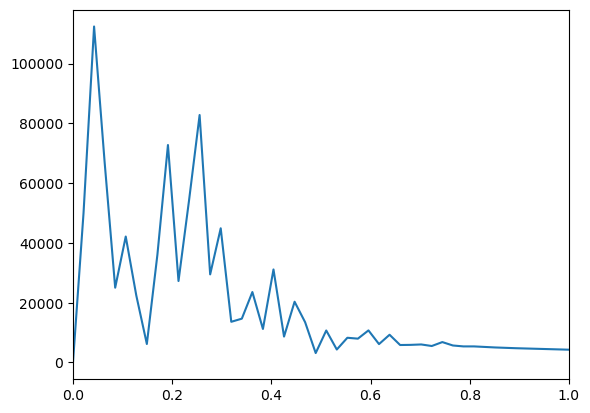

In [14]:
#gets and plots FFT of previous data after interpolation

from scipy.fft import rfft, rfftfreq
n = interpolated_rr.size

interpolated_rr = interpolated_rr - np.mean(interpolated_rr) #remove DC 

rfft = rfft(interpolated_rr)
rfftfreq = rfftfreq(n, 1/fs)

plt.plot(rfftfreq, np.abs(rfft)) #plots magnitude in frequency of data
plt.xlim(0, 1)

(0.0, 1.0)

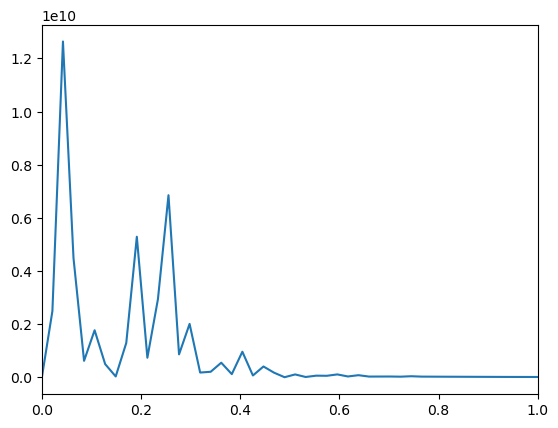

In [15]:
#gets and plots the power of previous spectrum

mag = np.abs(rfft)
power = mag**2

plt.plot(rfftfreq, power)
plt.xlim(0, 1)

In [17]:
#gets the HF, LF, HF/LF parameters to be used in the neural network 

lf_mask = (rfftfreq >= 0.04) & (rfftfreq <= 0.15)
lf_power = np.trapz(power[lf_mask], rfftfreq[lf_mask])

hf_mask = (rfftfreq >= 0.15) & (rfftfreq <= 0.4)
hf_power = np.trapz(power[hf_mask], rfftfreq[hf_mask])

total_power = lf_power + hf_power 
lf_nu = lf_power/total_power
hf_nu = hf_power/total_power
ratio = hf_nu/lf_nu

print(lf_nu, hf_nu, ratio)

0.4024513253091538 0.5975486746908463 1.484772535490654


## Then, MET

### First method is calculating MET through calories burnt while doing an activity. The files received from the device contain accumulative calories which means I will have to look into the equation a little bit. 

In [7]:
#MET = cal / (kg * hours)
import pandas as pd 

kg =  64
cal = df['calorie']
timestamp = df['sample_time']
time_size = timestamp.size

#get calories
cal_size = cal.size 
calories = cal[cal_size-1]

#get duration of exercise in hours
t1 = pd.to_datetime(timestamp[0])
t2 = pd.to_datetime(timestamp[time_size-1])
duration = (t2-t1).seconds/(60*60)

#calculate MET
total_MET = calories / (64*duration)

## Produce data file

In [ ]:
#turn this whole thing into one big function and you're done! 

data = [{"index" : None, "duration": None, "RMSSD": RMSSD, "pNN50": None, "HF": hf_nu, "LF": lf_nu, "HF/LF": ratio, "MET": total_MET, "temperature": None, "thermal_comfort": None }]

with open('processed_data.csv', 'a') as csvfile:
    fieldnames = ['index', 'duration', 'RMSSD', 'pNN50', 'HF', 'LF', 'HF/LF', 'MET', 'temperature', 'thermal_comfort']
    writer = csv.DictWriter(csvfile, fieldnames= fieldnames)
    writer.writerows(data)


## Now, neural network

I think i will be moving this to its own foldre so i can produce a file here with all the data that i will be needing. 

#### Data preprocessing

In [ ]:
#data normalization

from sklearn.preprocessing import StandardScaler

arraythatimimporting = []

scaler = StandardScaler()
scaler.fit(arraythatimimporting)

#### Neural network

In [ ]:
#this is the network without being actually shaped to the imports we're doing 

import tensorflow as tf
from tensorflow.python.keras import layers, models

num_features = 0 #amount of features on import 
num_classes = 3 #amount of classes on output, doing classification

model = models.Sequential([
    layers.Input(shape = (num_features,)),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32, activation = 'relu'), 
    layers.Dense(16, activation = 'relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

model.summary()


In [ ]:
#here we need to fit and run the model